In [190]:
# https://github.com/karpathy/micrograd

In [166]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Manual Gradient

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
x = np.arange(-5, 5.25, 0.25)
y = f(x)

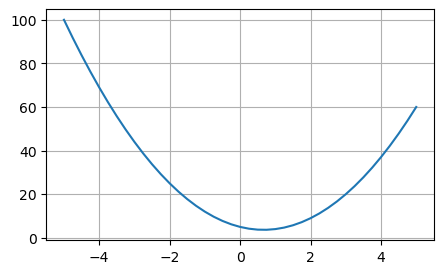

In [4]:
plt.figure(figsize=(5,3))
plt.plot(x, y); plt.grid();

In [5]:
h = 0.00001
x = 3
(f(x+h)-f(x))/h

14.00003000000538

In [6]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a += h 
d2 = a*b + c

(d2-d1)/h

-3.000000000010772

In [5]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # by default this variable not changing or effect the loss function
        self._prev = set(_children) # set of tuple: unchange and ordered
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = [], []
    def build(value):
        if value not in nodes:
            nodes.append(value)
            for child in value._prev:
                edges.append((child, value))
                build(child)            
    build(root)
    return nodes, edges

def draw_dot(root, format="svg", rankdir="LR"):
    # format: svg and png
    # rankdir: LR, TB, RL, BT
    nodes, edges = trace(root)
    dot = Digraph(comment="Computational Graphs", format=format, graph_attr={"rankdir": rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

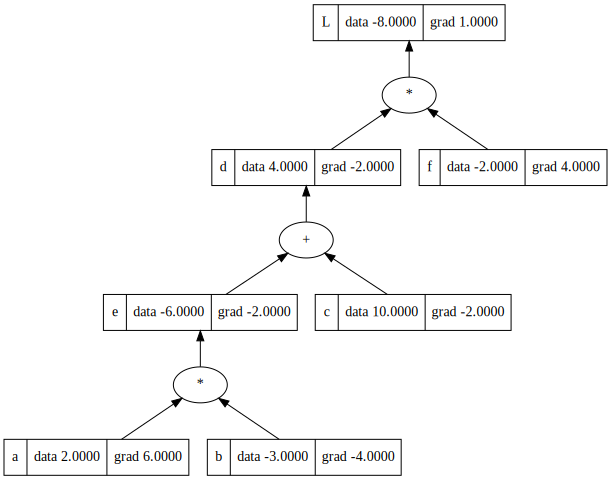

In [59]:
draw_dot(L, "svg", "BT")

In [58]:
# Manual Gradient
L.grad = 1.0

# dL/df = constant * f
f.grad = d.data

# dL/dd = constant * d
d.grad = f.data

# dL/dc = dL/dd * dd/dc
# dd/dc = constant + c = 1.0
c.grad = 1.0 * d.grad

# dL/de = dL/dd * dd/de
# dd/de = constant + e = 1.0
e.grad = 1.0 * d.grad

# dL/db = dL/dd * dd/de * de/db
# dL/db = dL/de * de/db
b.grad = a.data * e.grad

# dL/da = dL/dd * dd/de * de/da
# dL/da = dL/de * de/da
a.grad = b.data * e.grad

In [65]:
# optimize step
lr = 0.01
a.data += lr*a.grad
b.data += lr*b.grad
c.data += lr*c.grad
f.data += lr*f.grad

e = a*b
d = e+c
L = d*f

print(L)

Value(data=-4.572000000000001)


In [49]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    
    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()

6.000000000021544


In [167]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.881373, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
out = n.tanh(); out.label='out'
out

Value(data=0.7071064876766542)

In [168]:
out.grad = 1.0

# out = tanh(n) 
# dout/dn = 1 - tanh(n)**2 = 1 - out**2
n.grad = 1 - out.data**2

b.grad = 1.0 * n.grad
x1w1x2w2.grad = 1.0 * n.grad

x1w1.grad = 1.0*x1w1x2w2.grad
x2w2.grad = 1.0*x1w1x2w2.grad

x1.grad = w1.data*x1w1.grad
x2.grad = w2.data*x2w2.grad

w1.grad = x1.data*x1w1.grad
w2.grad = x2.data*x2w2.grad

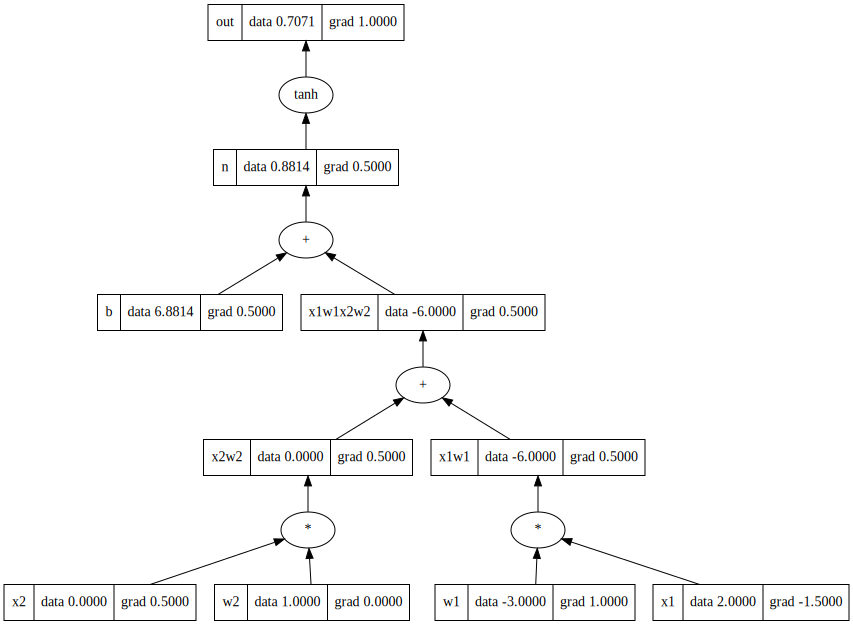

In [169]:
draw_dot(out, rankdir='BT')

# Auto Gradient

In [477]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by default this variable not changing or effect the loss function
        self._backward = lambda: None
        self._prev = set(_children) # set of tuple: unchange and ordered
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad # += mean chain rule multivariable case
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other.__add__(self) -> self.__add__(other)
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other.__mul__(self) -> self.__mul__(other)
        return self * other
    
    def __neg__(self): # negative self
        return -1 * self
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other.__sub__(self) -> self.__sub__(other)
        return self - other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), f"Input type should be int/float: {type(other)}"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return other * (self**-1)
    
    def exp(self):
        x = self.data
        exp = math.exp(x)
        out = Value(exp, (self, ), 'exp')
        def _backward():
            self.grad += exp * out.grad
        out._backward = _backward
        return out
    
    # activation funcitons
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1-t**2) *out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(self.data if self.data>0 else 0, (self, ), 'relu')
        def _backward():
            pass
        return out
    
    def backward(self):
        # build topological sort graph
        stack = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                    visited.add(v)
                    for adjs_v in v._prev:
                        build_topo(adjs_v)
                    stack.append(v)
                    
        build_topo(self)
        stack.reverse()
        
        # backward apply chain rule to get gradient
        self.grad = 1.0
        for v in stack:
            v._backward()

In [478]:
from graphviz import Digraph

def trace(root):
    nodes, edges = [], []
    def build(value):
        if value not in nodes:
            nodes.append(value)
            for child in value._prev:
                edges.append((child, value))
                build(child)            
    build(root)
    return nodes, edges

def draw_dot(root, format="svg", rankdir="LR"):
    # format: svg and png
    # rankdir: LR, TB, RL, BT
    nodes, edges = trace(root)
    dot = Digraph(comment="Computational Graphs", format=format, graph_attr={"rankdir": rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [145]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.881373, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

out = n.tanh(); out.label='out'
out

Value(data=0.7071064876766542)

In [146]:
out.backward()

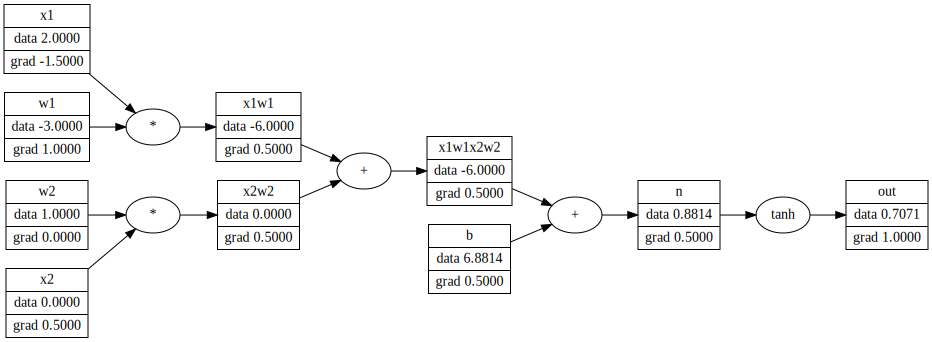

In [147]:
draw_dot(out, "svg", "LR")

# Build Neural Network by Value

In [310]:
class Neuron:
    def __init__(self, n_in: int):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.bias = Value(random.uniform(-1, 1))
    
    def __repr__(self):
        return f"[w:{[i for i in self.weight]} b:{self.bias}]"
        
    def __call__(self, x):
        out = sum([wi*xi for wi, xi in zip(self.weight, x)], self.bias)
        act_out = out.tanh()
        return act_out
    
    def parameters(self):
        return self.weight + [self.bias]

class Layer: # for connect with other layer
    def __init__(self, n_in: int, n_out: int):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
            
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out
    
    def __repr__(self):
        return f"Layer:[{', '.join(str(n) for n in self.neurons)}]"
    
    def parameters(self):
        return  [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, n_in: int, n_out: int, hiddens: list): 
        sz = [n_in] + hiddens + [n_out]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]
    
    def __repr__(self):
        return f"MLP:[{', '.join(str(l) for l in self.layers)}]"
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [311]:
random.seed(7)
x = [2.0, 3.0, -1.0]
n = MLP(n_in=3, n_out=1, hiddens=[4, 4])
out = n(x)
out

[Value(data=-0.2984600875613527)]

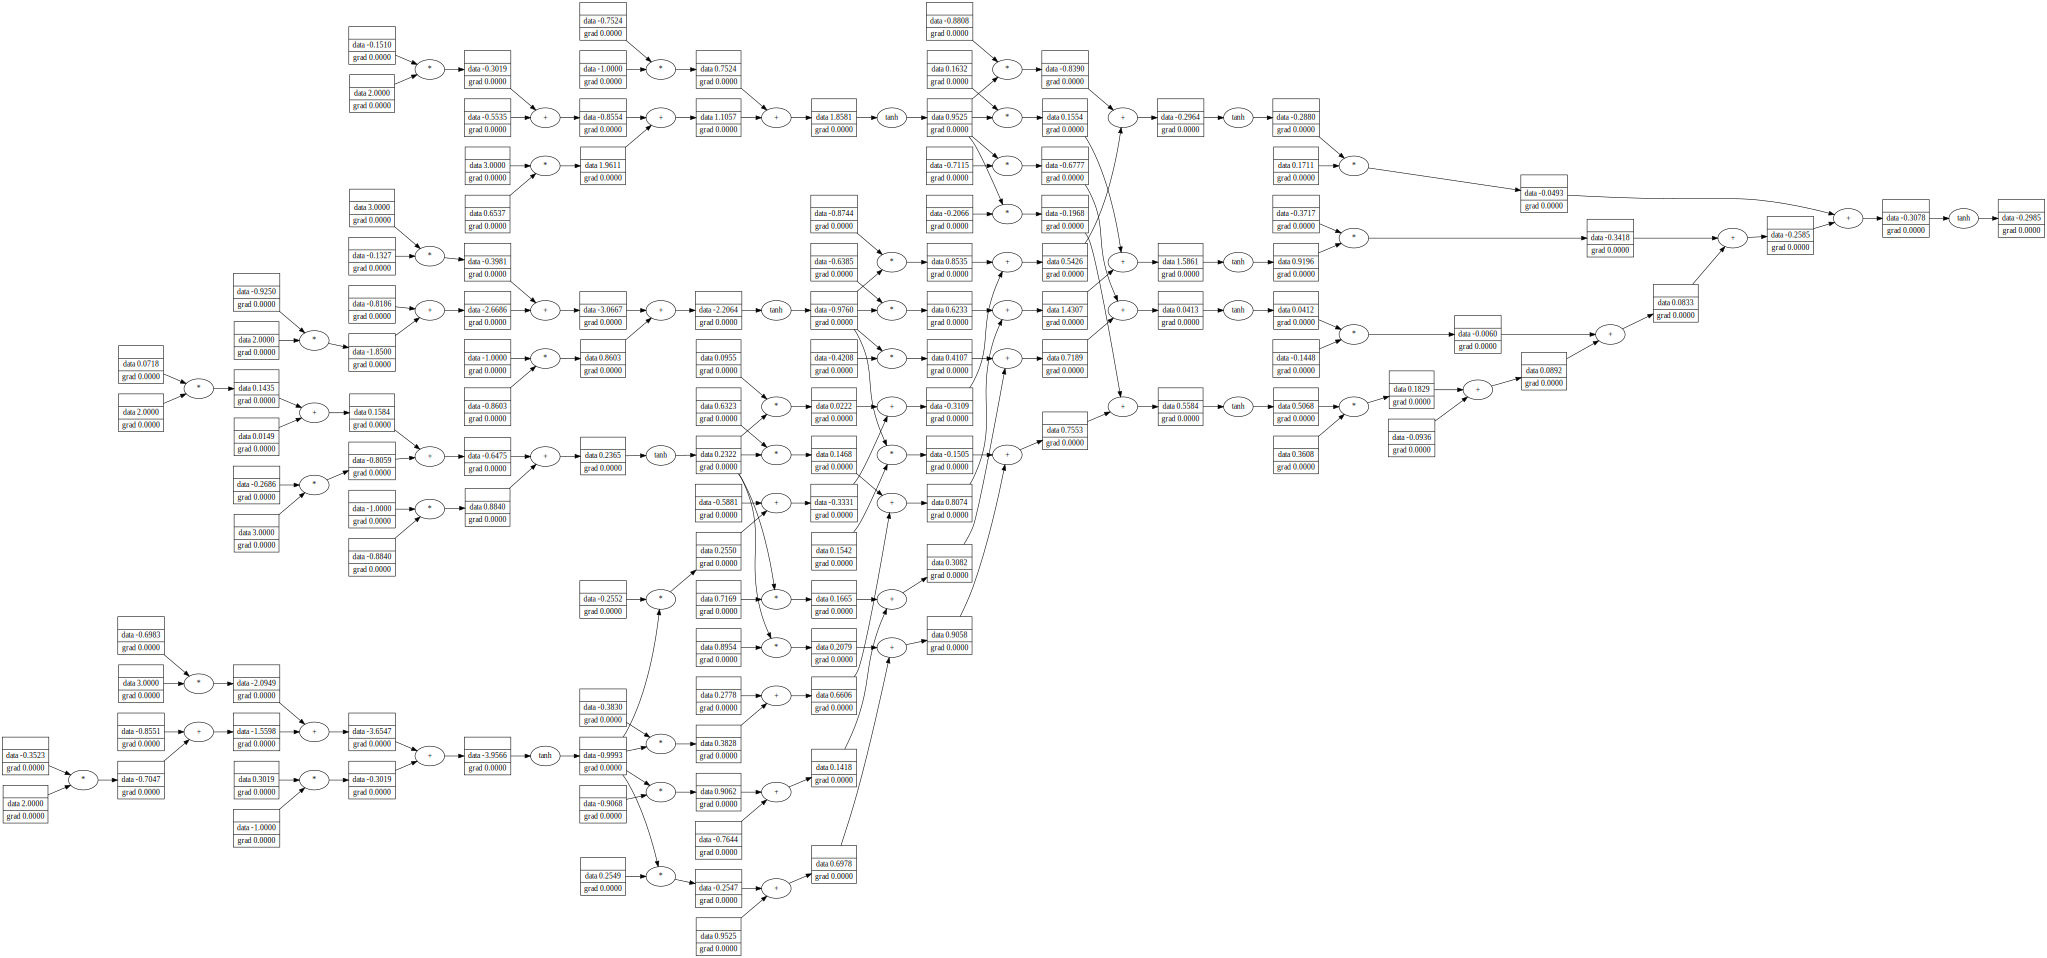

In [293]:
draw_dot(out[0])

In [362]:
def mse_loss(pred, target):
    loss = sum((y_true-y_pred)**2 for y_pred, y_true in zip(pred, target))/len(target)
    return loss

In [363]:
n = MLP(3, 1, [4,4])

In [364]:
# data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [365]:
epochs = 101
lr = 0.05

for epoch in range(epochs):
    # prediction
    y_pred = [n(x)[0] for x in xs]

    # calculate the loss
    loss = mse_loss(y_pred, ys)

    # set zero grad
    for p in n.parameters():
        p.grad = 0.0

    # backward
    loss.backward()

    # update parameters (step)
    for p in n.parameters():
        p.data += -lr*p.grad
    
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.data:.4f}")

Epoch: 0 | Loss: 0.8862
Epoch: 5 | Loss: 0.3500
Epoch: 10 | Loss: 0.2200
Epoch: 15 | Loss: 0.1393
Epoch: 20 | Loss: 0.0932
Epoch: 25 | Loss: 0.0663
Epoch: 30 | Loss: 0.0498
Epoch: 35 | Loss: 0.0390
Epoch: 40 | Loss: 0.0316
Epoch: 45 | Loss: 0.0262
Epoch: 50 | Loss: 0.0223
Epoch: 55 | Loss: 0.0193
Epoch: 60 | Loss: 0.0169
Epoch: 65 | Loss: 0.0150
Epoch: 70 | Loss: 0.0134
Epoch: 75 | Loss: 0.0122
Epoch: 80 | Loss: 0.0111
Epoch: 85 | Loss: 0.0102
Epoch: 90 | Loss: 0.0094
Epoch: 95 | Loss: 0.0087
Epoch: 100 | Loss: 0.0081


In [366]:
y_pred = [n(x)[0] for x in xs]
y_pred, ys

([Value(data=0.893570004352258),
  Value(data=-0.9834928999126249),
  Value(data=-0.8888748626151003),
  Value(data=0.910415983648426)],
 [1.0, -1.0, -1.0, 1.0])

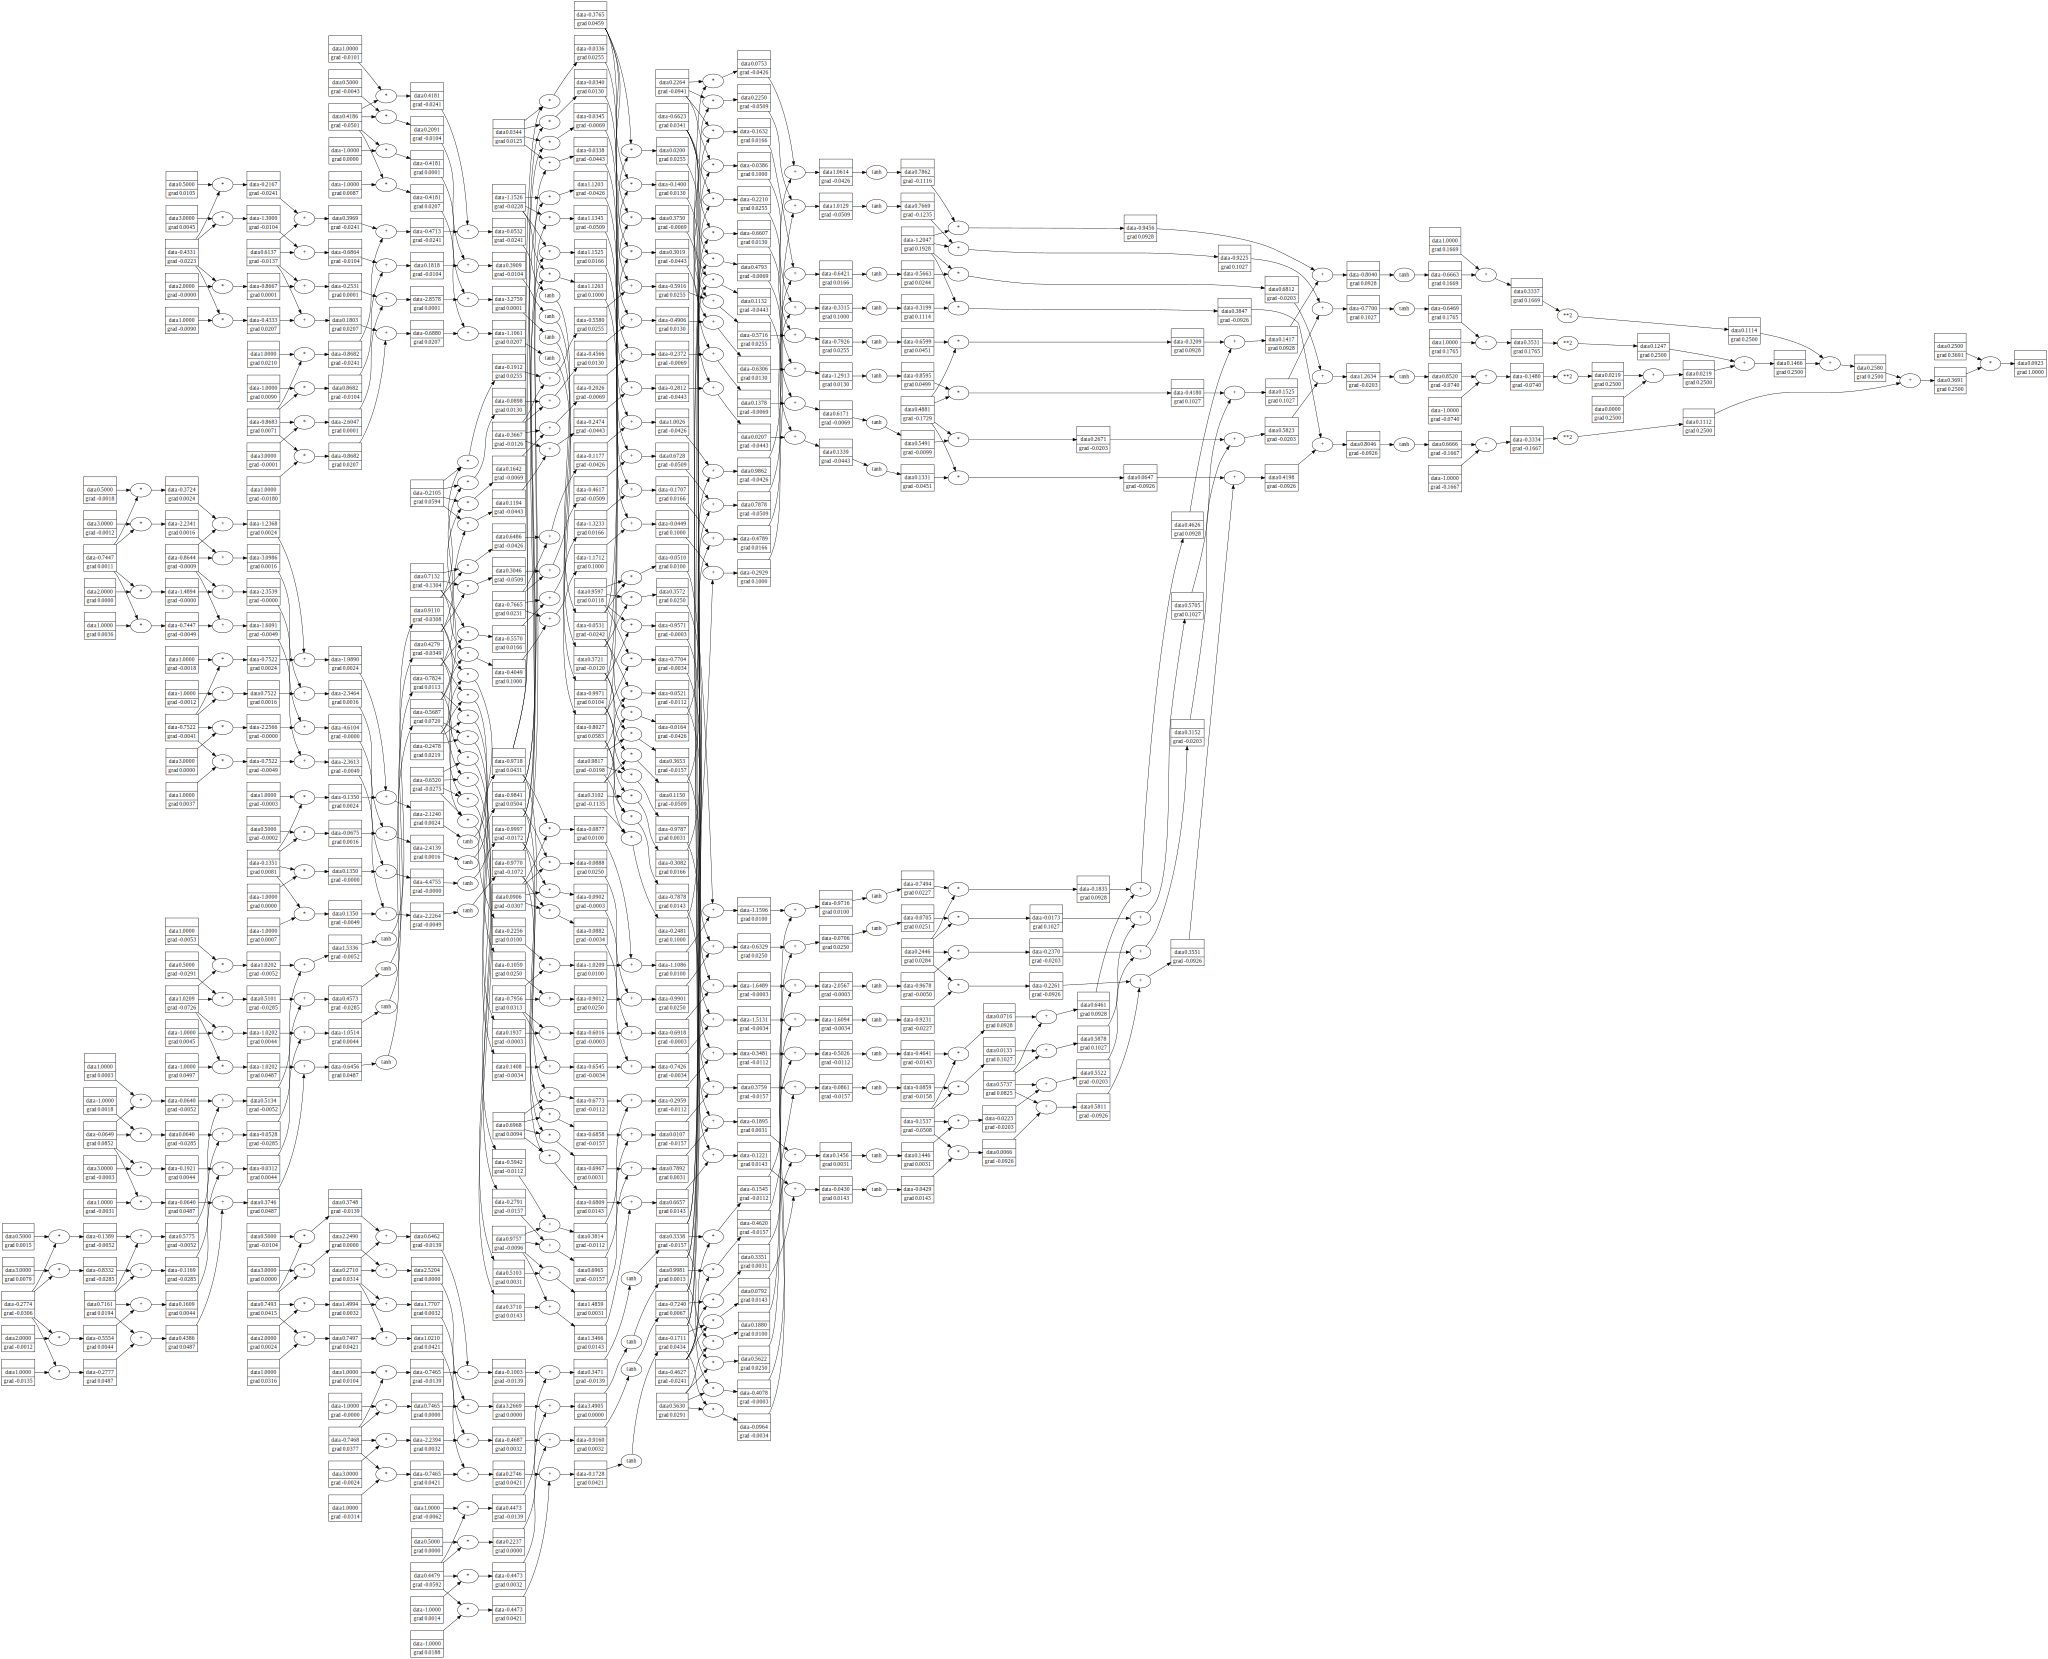

In [353]:
draw_dot(loss)

# Gradient based optimization

In [449]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
%matplotlib notebook

In [592]:
def func(x1, x2):
    return x1*x1-x2*x2

In [467]:
def func(x1, x2):
    return np.exp(-1*(x1**2+x2**2))

In [593]:
x1 = np.arange(-2, 2.1, 0.1)
x2 = np.arange(-2, 2.1, 0.1)

x1, x2 = np.meshgrid(x1, x2)

p = np.array(list(map(func, x1, x2)))

<IPython.core.display.Javascript object>


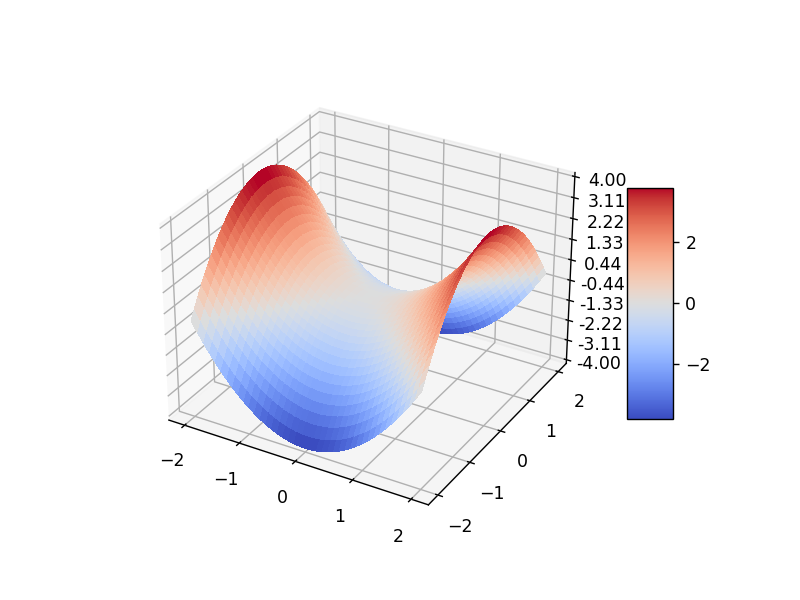

In [594]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x1, x2, p, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Gradient ascent func1

In [587]:
lr = 0.1
fx = []
a_x = []
b_x = []

In [588]:
for i in range(150):
    c = -1*(a**2+b**2); a.label='c'
    e = c.exp(); e.label='e'
    a_x.append(a.data)
    b_x.append(b.data)
    fx.append(e.data)
    if i % 10 == 0:
        print(f"f(x1, x2) = {e.data:.4f}")

    # zero grad
    a.grad = 0
    b.grad = 0

    # gradient backward
    e.backward()

    # Update step
    a.data += lr*a.grad
    b.data += lr*b.grad

f(x1, x2) = 0.0179
f(x1, x2) = 0.0246
f(x1, x2) = 0.0373
f(x1, x2) = 0.0665
f(x1, x2) = 0.1626
f(x1, x2) = 0.6092
f(x1, x2) = 0.9881
f(x1, x2) = 0.9999
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000
f(x1, x2) = 1.0000


<IPython.core.display.Javascript object>


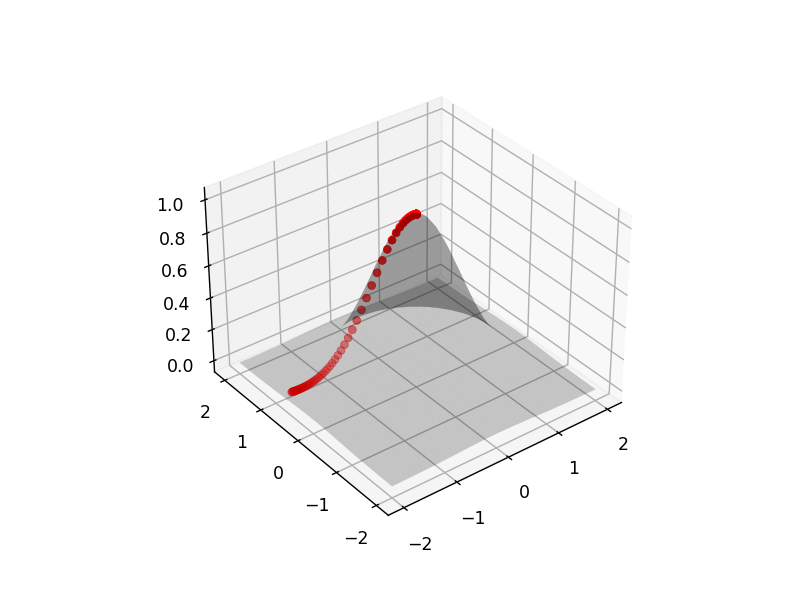

In [591]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(-2, 2.1, 0.1)
x2 = np.arange(-2, 2.1, 0.1)
x1, x2 = np.meshgrid(x1, x2)
def func(x1, x2):
    return np.exp(-1*(x1**2+x2**2))
p = np.array(list(map(func, x1, x2)))

# Create a 3D plot of the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1, x2, p)

# Set the transparency of the surface plot
surf.set_facecolor((0,0,0,0.2))

a_x = np.array(a_x)
b_x = np.array(b_x)
#a_x, b_x= np.meshgrid(a_x, b_x)
def func(x1, x2):
    return np.exp(-1*(x1**2+x2**2))
fx = np.array(list(map(func, a_x, b_x)))

ax.scatter(a_x, b_x, fx, color='red', linewidth=0.5, zorder=-1)

# Show the plot
plt.show()


In [584]:
# a_x = np.array(a_x)
# b_x = np.array(b_x)
# #a_x, b_x= np.meshgrid(a_x, b_x)

# def func(x1, x2):
#     return np.exp(-1*(x1**2+x2**2))

# fx = np.array(list(map(func, a_x, b_x)))

# x1 = np.arange(-2, 2.1, 0.1)
# x2 = np.arange(-2, 2.1, 0.1)

# x1, x2 = np.meshgrid(x1, x2)

# def func(x1, x2):
#     return np.exp(-1*(x1**2+x2**2))

# p = np.array(list(map(func, x1, x2)))

# # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# fig = plt.figure(figsize=(8,6))
# ax = plt.axes(projection='3d')

# surf = ax.plot_surface(x1, x2, p, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False, zorder=1)
# ax.scatter(a_x, b_x, fx, c='g', marker='o', zorder=2)
# #ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()

# Gradient ascent func2

In [630]:
def func(x1, x2):
    return x1*x1-x2*x2

<IPython.core.display.Javascript object>


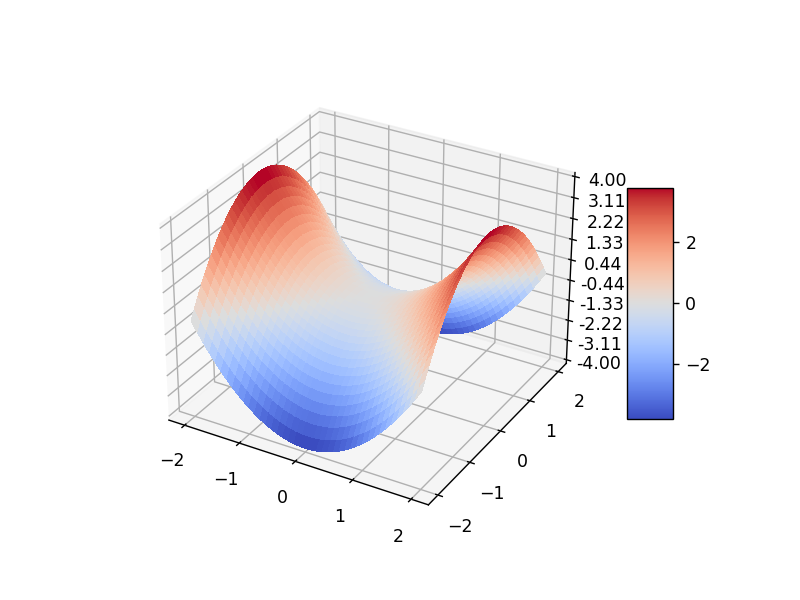

In [631]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x1, x2, p, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [648]:
random.seed(43)
a = Value(random.uniform(-0.1, 0.1), label='x1')
b = Value(random.uniform(-2.5, -1.5), label='x2')
e = a*a - b*b; e.label='e'

e.backward()

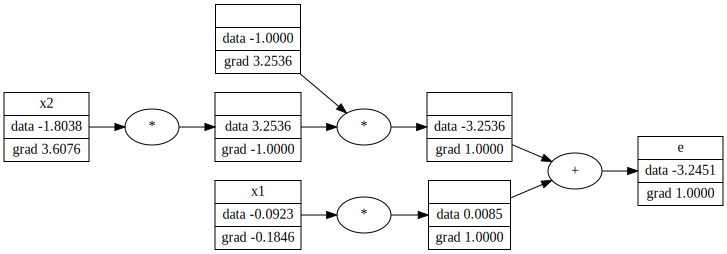

In [649]:
draw_dot(e)

In [650]:
lr = 0.01
fx = []
a_x = []
b_x = []

for i in range(150):
    e = a*a - b*b; e.label='e'
    a_x.append(a.data)
    b_x.append(b.data)
    fx.append(e.data)
    if i % 10 == 0:
        print(f"f(x1, x2) = {e.data:.4f}")

    # zero grad
    a.grad = 0
    b.grad = 0

    # gradient backward
    e.backward()

    # Update step
    a.data += lr*a.grad
    b.data += lr*b.grad

f(x1, x2) = -3.2451
f(x1, x2) = -2.1595
f(x1, x2) = -1.4313
f(x1, x2) = -0.9402
f(x1, x2) = -0.6048
f(x1, x2) = -0.3698
f(x1, x2) = -0.1964
f(x1, x2) = -0.0561
f(x1, x2) = 0.0741
f(x1, x2) = 0.2151
f(x1, x2) = 0.3898
f(x1, x2) = 0.6261
f(x1, x2) = 0.9616
f(x1, x2) = 1.4497
f(x1, x2) = 2.1681


<IPython.core.display.Javascript object>


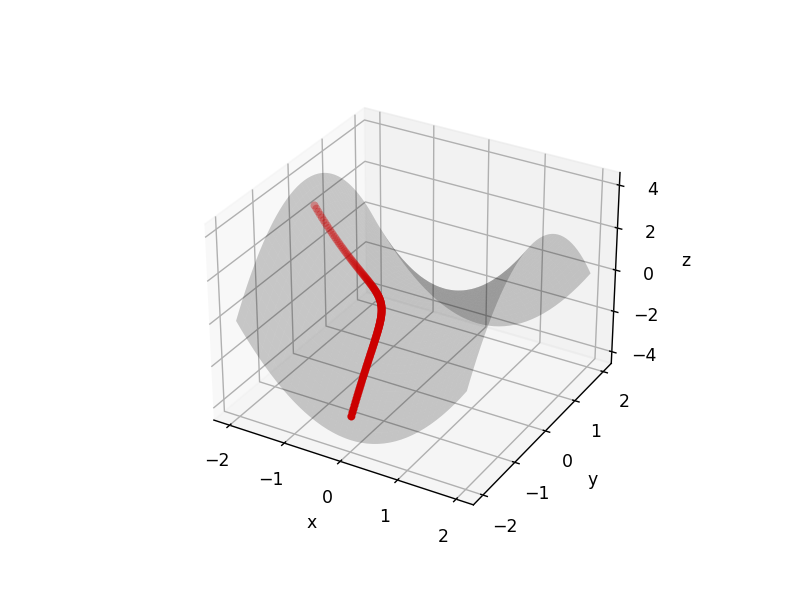

In [651]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(-2, 2.1, 0.1)
x2 = np.arange(-2, 2.1, 0.1)
x1, x2 = np.meshgrid(x1, x2)
p = np.array(list(map(func, x1, x2)))

# Create a 3D plot of the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1, x2, p)

# Set the transparency of the surface plot
surf.set_facecolor((0,0,0,0.2))

a_x = np.array(a_x)
b_x = np.array(b_x)
#a_x, b_x= np.meshgrid(a_x, b_x)
fx = np.array(list(map(func, a_x, b_x)))

ax.scatter(a_x, b_x, fx, color='red', linewidth=0.1, zorder=-1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


In [652]:
a, b

(Value(data=-1.7996111660748642), Value(data=-0.0871151884324075))